# MNIST VAE without latent structure

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints

from helper_functions import *
from encoder_decoder_vae import *

### Define the simulation parameters

In [ ]:
params = { 
    'K' : 10, #number of clusters
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28,
    'Z_DIM':2,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

### Get the data

In [ ]:
BATCH_SIZE = 64
kwargs = {'num_workers': 8, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:8],npadding=4)

### Define the VAE class

In [ ]:
class VAE_no_latent_structure(torch.nn.Module):
    
    def __init__(self,params,encoder,decoder):
        super().__init__()
        
        # Parameters
        self.use_cuda = params['use_cuda']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        # Instantiate the encoder and decoder
        self.decoder = decoder
        self.encoder = encoder
        
        if(self.use_cuda):
            self.cuda()
        
    def guide(self, imgs=None):
        """ 1. run the inference 
            2. sample latent variables 
        """       
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#

        batch_size,ch,width,height = imgs.shape
        pyro.module("encoder", self.encoder)
        z_mu,z_std = self.encoder(imgs)
        with pyro.plate('batch_size', batch_size, dim=-1):
            z = pyro.sample('z_latent', dist.Normal(z_mu,z_std).to_event(1))
        return z_mu,z_std
            
    def model(self, imgs=None):
        """ 1. sample the latent from the prior:
            2. runs the generative model
            3. score the generative model against actual data 
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        batch_size,ch,width,height = imgs.shape
        pyro.module("decoder", self.decoder)
        with pyro.plate('batch_size', batch_size, dim=-1):
            z = pyro.sample('z_latent', dist.Normal(imgs.new_zeros(self.z_dim),10*imgs.new_ones(self.z_dim)).to_event(1))
            x_mu = self.decoder(z) #x_mu is between 0 and 1
            pyro.sample('obs', dist.Bernoulli(x_mu.view(batch_size,-1)).to_event(1), obs=imgs.view(batch_size,-1))
        return x_mu
    
    def reconstruct(self,imgs):
        z_mu,z_std = self.encoder(imgs)
        x = self.decoder(z_mu)
        return x

In [ ]:
encoder = MLP_x_to_z(params)
decoder = MLP_z_to_x(params)
vae = VAE_no_latent_structure(params,encoder,decoder)
vae.guide()
vae.model()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [ ]:
test_model(vae.model,vae.guide,Trace_ELBO())

#load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")

import pyro.poutine as poutine
#
print("----MODEL---------")
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())
#
print("----GUIDE ---------")
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

In [ ]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 10001
    
# setup the optimizer
adam_args = {"lr": 1.0e-4}
#optimizer = Adadelta(adam_args)
optimizer = Adamax(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
loss_train_history = list()
loss_test_history = list()
min_loss = 999999

In [ ]:
write_dir  = '/Users/ldalessi/clustering/ARCHIVE/'
name_vae  = "vae_no_structure_v1_"
name_train_loss = "loss_train_no_structure_v1_"
name_test_loss = "loss_test_no_structure_v1_"
save_obj(params,write_dir,"params_no_structure_v1_")


# training loop
for epoch in range(10,NUM_EPOCHS):
    vae.train()    
    loss = train(svi,trainloader,use_cuda=params['use_cuda'])
    loss_train_history.append(loss)
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
       
    if(epoch < 4 % 20): 
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_train_history,write_dir,name_train_loss+str(epoch))
        save_obj(loss_test_history,write_dir,name_test_loss+str(epoch))
    
    if(epoch % 5 ==0):
        vae.eval()
        loss_test = evaluate(svi,testloader,use_cuda=params['use_cuda'])
        loss_test_history.append(loss_test)
        if(loss_test < min_loss):
            min_loss = loss_test
            save_model(vae,write_dir,name_vae+str(epoch))       
            save_obj(loss_train_history,write_dir,name_train_loss+str(epoch))
            save_obj(loss_test_history,write_dir,name_test_loss+str(epoch))
            print("[epoch %03d]  test loss: %.4f --New Record--" % (epoch, loss)) 
        else:
            print("[epoch %03d]  test loss: %.4f" % (epoch, loss)) 

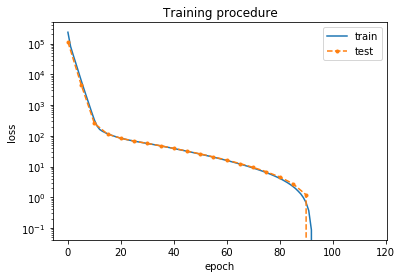

In [12]:
plt.plot(np.arange(0, len(loss_train_history)), np.array(loss_train_history))
plt.plot(np.arange(0, len(loss_train_history), TEST_FREQUENCY), np.array(loss_test_history), '.--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training procedure')
plt.legend(['train', 'test'])
plt.show()

(-1.0, 1.0)

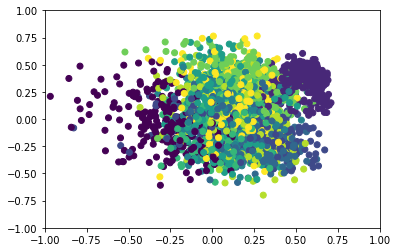

In [17]:
# compute the embedding

z = torch.empty([1, params['Z_DIM']])
labels = torch.empty(1)

for data in testloader:
    
    if z.shape[0] >= 3000:
        break
    
    imgs,labs = data
    if(params['use_cuda']):
        imgs=imgs.cuda()
    z_mu_tmp, z_std_tmp = vae.encoder(imgs)
    
    z = torch.cat((z,z_mu_tmp.detach().cpu().numpy()),dim=0)
    labels = torch.cat((labels, labs.numpy()),dim=0)

   
plt.scatter(z[:,0],z[:,1],c=labels)    
plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)

In [ ]:
imgs,labels = next(iter(testloader))
imgs_rec = vae.reconstruct(imgs.cuda())
show_batch(imgs)
show_batch(imgs_rec)